## Description:
Run many models looking at:
1 - BMI and omic variables longitudinally 
2 - BMI and variable changes from BL-6m and 6m-12m

In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib as mpl
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats
from joblib import dump
sns.set_context("poster")
mpl.rcParams['figure.figsize'] = (11,8)

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# test and train set directories for input data
longitudinal_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined/"
delta_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/zachs_rerun/drift_fs/csv/all_omic_processed_data/deltas/"
clin_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2/merf_ready"
# Where hyperparameter training results are
delta_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/6.two_timepoints_deltas"
long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined"
func_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/3.functional"
taxa_long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/2.taxa"
clinical_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical"
micom_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/4.micom"

In [ ]:
# test and train longitudinal files 
test_all = pd.read_csv(os.path.join(longitudinal_dir, 'feb20_test_merged_all_omics_raw_meta.csv'))  
train_all = pd.read_csv(os.path.join(longitudinal_dir, 'feb20_training_merged_all_omics_raw_meta.csv'))  
print("test long shape = ", test_all.shape)
print("train long shape = ", train_all.shape)
print("test longitudinal: ", test_all.columns)
print("train longitudinal: ", train_all.columns)

# test and train delta files 
test_delta = read_data(delta_dir, "feb20_all_delta_test.csv")
train_delta = read_data(delta_dir, "feb20_all_delta_train.csv")
print("test delta shape = ", test_delta.shape)
print("train delta shape = ", train_delta.shape)
print("test delta: ", test_delta.columns)
print("train delta: ", train_delta.columns)

# hyperparameter training files 
delta_df = pd.read_csv(os.path.join(delta_df_dir, 'jan30_2times_all_omic_deltas_BMI_remove_time_var_imputed_swapped.csv'))
long_df = pd.read_csv(os.path.join(long_df_dir, 'jan13_params_fine_tuning_results_all_omics.csv'))
func_df = pd.read_csv(os.path.join(func_df_dir, 'dec6_magggie_params_fine_tuning_results_raw_functional.csv'))
taxa_df = pd.read_csv(os.path.join(taxa_long_df_dir, 'dec6_maggie_params_tuning_raw_taxa_oob.csv'))
micom_df = pd.read_csv(os.path.join(micom_df_dir, 'dec6_maggie_params_fine_tuning_results_raw_micom.csv'))
meta_df = pd.read_csv(os.path.join(clinical_df_dir, 'dec5_maggie_params_tuning_raw_clinical_oob.csv'))
#meta_df = pd.read_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical/fine_tuning_results_raw_clinical.csv')

### Longitudinal BMI first 

In [ ]:
# Drop some columns 
train_long = train_all.drop(['Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_x', 'all_samples_y', 'record_id','SampleID',
                    'time_x', 'time_y', 'x_t', 't', 'outcome_BMI_fnl_x',], 
                    axis=1)

test_long = test_all.drop(['Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_x', 'all_samples_y', 'record_id', 'SampleID',
                    'time_x', 'time_y', 'x_t', 't', 'outcome_BMI_fnl_x'], 
                    axis=1)
print("test long shape = ", test_long.shape)
print("train long shape = ", train_long.shape)

test_long.rename(columns={'outcome_BMI_fnl_test_long': 'outcome_bmi_fnl'}, inplace=True)
train_long.rename(columns={'outcome_BMI_fnl_train_long': 'outcome_bmi_fnl'}, inplace=True)

print("test longitudinal: ", list(test_long.columns))
print("train longitudinal: ", list(train_long.columns))

In [4]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_long.columns.get_loc("proton")
carbon_dioxide_column = train_long.columns.get_loc("Carbon.dioxide")
proton_column_test = test_long.columns.get_loc("proton")
carbon_dioxide_column_test = test_long.columns.get_loc("Carbon.dioxide")

# Columns to KEEP for only meta 
meta_keep = ['all_samples','outcome_bmi_fnl', 'time', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = ['all_samples','outcome_bmi_fnl', 'bmi_prs', 'time']
only_taxa = ['all_samples','outcome_bmi_fnl', 'time'] + [col for col in train_long.columns if col.startswith("g__")]
only_micom = ['all_samples','outcome_bmi_fnl', 'time'] + [col for col in train_long.columns if col in train_long.columns[proton_column:carbon_dioxide_column+1]]
# Create a set of all columns to exclude
exclude_columns = set(meta_keep + only_grs + only_taxa + only_micom)
only_pathway = ['all_samples', 'outcome_bmi_fnl', 'time'] + [col for col in train_long.columns if col not in exclude_columns]

# Columns to KEEP for only meta + GRS
meta_grs = ['all_samples','outcome_bmi_fnl', 'time','randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'bmi_prs']
# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_grs + [col for col in train_long.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_grs + [col for col in test_long.columns if col.startswith("g__")]
# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_long.columns if col not in train_long.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa + [col for col in test_long.columns if col not in test_long.columns[proton_column_test:carbon_dioxide_column_test+1]]
# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'cohort_number', 'time', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']

## 1.1 Trying Meta from omic DF

PTEV is the best one 
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

In [ ]:
train_l = train_long[meta_keep]
test_l = test_long[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_meta_merf_bmi_long_feb12_all.png'
feature_imp_out = 'fi_only_meta_merf_bmi_long_feb12_all.png'
results_filename = 'merf_results_long_only_meta_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])

print("---------- Run MERF models ----------")
#r2_run1, fi_run1 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

#print("---------- Run best MERF 🧮 ----------")# Define the parameter grid list
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# only_meta = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="only_meta_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in only_meta:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection


## Only PRS

In [ ]:
train_l = train_long[only_grs]
test_l = test_long[only_grs]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_grs_merf_bmi_long_feb12_all.png'
feature_imp_out = 'fi_only_grs_merf_bmi_long_feb12_all.png'
results_filename = 'merf_results_long_meta_grs_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])
print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only Taxa

In [ ]:
train_l = train_long[only_taxa]
test_l = test_long[only_taxa]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_taxa_merf_bmi_long_feb12.png'
feature_imp_out = 'fi_only_taxa_merf_bmi_long_feb12.png'
results_filename = 'merf_results_long_only_taxa_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])
print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only Micom

In [ ]:
train_l = train_long[only_micom]
test_l = test_long[only_micom]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_micom_merf_bmi_long_feb12.png'
feature_imp_out = 'fi_only_micom_merf_bmi_long_feb12.png'
results_filename = 'merf_results_long_only_micom_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])
print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only pathway data

In [ ]:
train_l = train_long[only_pathway]
test_l = test_long[only_pathway]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_pathway_merf_bmi_long_feb12.png'
feature_imp_out = 'fi_only_pathway_merf_bmi_long_feb12.png'
results_filename = 'merf_results_long_only_pathway_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples', 'time'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['time'])

print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## 1.2 trying Meta + Genetic info from omic DF
PTEV model
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

In [ ]:
train_l = train_long[meta_grs]
test_l = test_long[meta_grs]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_meta_grs_merf_bmi_long_feb10_all.png'
feature_imp_out = 'fi_meta_grs_merf_bmi_long_feb10_all.png'
results_filename = 'merf_results_long_meta_grs.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

print("---------- Run best MERF 🧮 ----------")# Define the parameter grid list
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# only_meta_grs = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="only_meta_grs_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in only_meta_grs:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")

## 1.3 trying Meta + Genetic + Taxa info from omic DF

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

In [ ]:
train_l = train_long[meta_grs_taxa]
test_l = test_long[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_grs_taxa_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_meta_grs_taxa_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)

r2_run3, fi_run3 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# meta_grs_tax = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="meta_grs_tax_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in meta_grs_tax:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection

## 1.4 trying Meta + Genetic + Taxa + Functional info from omic DF

lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64

In [ ]:
train_l = train_long[meta_grs_taxa_functional]
test_l = test_long[meta_grs_taxa_functional_test]
# Check for duplicate column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
# Remove duplicate columns
test_l = test_l.loc[:, ~test_l.columns.duplicated()]
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_grs_taxa_functional_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_meta_grs_taxa_functional_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)
# Run the analysis multiple times
r2_run4, fi_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
param_grid_list = [
    {'n_estimators': 500, 'max_depth': None, 
     'min_samples_split': 0.05, 'max_iter': 2}
]
# Call the run_merf function with the required parameters
#meta_grs_tax_func = run_merf(X, Y, Z, clusters_train,
#                     X_new, Y_new, Z_new, clusters_new, 
#                     param_grid_list, results_name="meta_grs_tax_func_results")
# View the "only_meta" output
#print("Viewing the 'only_meta' output:")
#for result in meta_grs_tax_func:
#    print(f"Model Parameters: {result['params']}")
#    print(f"R-squared: {result['r2']:.4f}")
#    print("Feature Importances:")
#    for feature, importance in zip(X.columns, result['feature_importances']):
#        print(f"{feature}: {importance:.4f}")
#    print("\n")

## 1.5 all but meta omic df 

First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64

In [ ]:
train_l = train_long.drop(all_but_meta, axis = 1)
test_l = test_long.drop(all_but_meta, axis = 1)
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_but_meta_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_all_but_meta_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)
r2_run5, fi_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# grs_tax_func_micom = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="grs_tax_func_micom")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in grs_tax_func_micom:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection

## 1.6 All omics 

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_omics_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_all_omics_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_long
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_long
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)

r2_run6, fi_run6 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
param_grid_list = [
    {'n_estimators': 100, 'max_depth': None, 
     'min_samples_split': 0.05, 'max_iter': 2}
]
# Call the run_merf function with the required parameters
# all_omic = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="grs_tax_func_micom")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in all_omic:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")

# Now looking at Delta models 

In [27]:
print("test delta: ", list(test_delta.shape))
print("train delta: ", list(train_delta.shape))
print("test delta: ", list(test_delta.columns))
print("train delta: ", list(train_delta.columns))

test delta:  [62, 920]
train delta:  [234, 920]
test delta:  ['subject_id', 'randomized_group', 'age', 'sex', 'race', 'BMI', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HDL', 'LDL', 'HbA1C', 'insulin', 'leptin', 'peptide_yy', 'tgcyd', 'homo_ir', 'DENOVOPURINE2-PWY', 'DHGLUCONATE-PYR-CAT-PWY', 'DTDPRHAMSYN-PWY', 'ECASYN-PWY', 'ENTBACSYN-PWY', 'FAO-PWY', 'FASYN-ELONG-PWY', 'FASYN-INITIAL-PWY', 'FERMENTATION-PWY', 'FOLSYN-PWY', 'FUC-RHAMCAT-PWY', 'FUCCAT-PWY', 'GALACT-GLUCUROCAT-PWY', 'GALACTARDEG-PWY', 'GALACTUROCAT-PWY', 'GALLATE-DEGRADATION-I-PWY', 'GALLATE-DEGRADATION-II-PWY', 'GLCMANNANAUT-PWY', 'GLUCARDEG-PWY', 'GLUCARGALACTSUPER-PWY', 'GLUCONEO-PWY', 'GLUCOSE1PMETAB-PWY', 'GLUCUROCAT-PWY', 'GLUTORN-PWY', 'GLYCOCAT-PWY', 'GLYCOGENSYNTH-PWY', 'GLYCOL-GLYOXDEG-PWY', 'GLYCOLYSIS', 'GLYCOLYSIS-E-D', 'GLYCOLYSIS-TCA-GLYOX-BYPASS', 'GLYOXYLATE-BYPASS', 'GOLPDLCAT-PWY', 'HCAMHPDEG-PWY', 'HEME-BIOSYNTHESIS-II', 'HEMESYN2-PWY', 'HEXITOLDEGSUPER-PWY', 'HISDEG-PWY', 'HISTSYN-PWY', 'HOMOSER-MET

In [30]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_delta.columns.get_loc("proton")
carbon_dioxide_column = train_delta.columns.get_loc("Carbon.dioxide")
proton_column_test = test_delta.columns.get_loc("proton")
carbon_dioxide_column_test = test_delta.columns.get_loc("Carbon.dioxide")
print("Column number for 'proton': ", proton_column)
print("Column number for 'Carbon.dioxide': ", carbon_dioxide_column)

# Columns to KEEP for only meta 
meta_keep = ['subject_id','BMI', 'range', 'randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd']
only_grs = ['subject_id','BMI', 'bmi_prs', 'range']
only_taxa = ['subject_id','BMI', 'range'] + [col for col in train_delta.columns if col.startswith("g__")]
only_micom = ['subject_id','BMI', 'range'] + [col for col in train_delta.columns if col in train_delta.columns[proton_column:carbon_dioxide_column+1]]
# Create a set of all columns to exclude
exclude_columns = set(meta_keep + only_grs + only_taxa + only_micom)
only_pathway = ['subject_id', 'BMI', 'range'] + [col for col in train_delta.columns if col not in exclude_columns]


# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_keep + [col for col in train_delta.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_keep + [col for col in test_delta.columns if col.startswith("g__")]

# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_delta.columns if col not in train_delta.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa_test + [col for col in test_delta.columns if col not in test_delta.columns[proton_column_test:carbon_dioxide_column_test+1]]

# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy']

Column number for 'proton':  828
Column number for 'Carbon.dioxide':  918


## 2.1 Only Meta Delta 

In [ ]:
# Check for missing columns in train_delta
missing_columns = [col for col in meta_keep if col not in train_delta.columns]

if missing_columns:
    print("Missing columns in train_delta:", missing_columns)
else:
    print("All columns in meta_keep are present in train_delta.")

In [ ]:
train_l = train_delta[meta_keep]
test_l = test_delta[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_only_meta_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_only_meta_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_only_meta_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

#### Only delta taxa

In [29]:
# Check for missing columns in train_delta
missing_columns = [col for col in only_taxa if col not in train_delta.columns]

if missing_columns:
    print("Missing columns in train_delta:", missing_columns)
    print("taxa_cols:" , only_taxa)
else:
    print("All columns in only_taxa are present in train_delta.")

Missing columns in train_delta: ['g__CAG.1427', 'g___2', 'g___3', 'g___4', 'g__CCUG.7971', 'g___5', 'g__CAG.269', 'g___6', 'g__CAG.273', 'g__CAG.41', 'g___7', 'g__CAG.83', 'g___8', 'g___9', 'g__CAG.177', 'g__CAG.217', 'g___10', 'g___11', 'g__CAG.274', 'g__CAG.45', 'g___1', 'g__CAG.127', 'g__CAG.95', 'g__CAG.317_146760']
taxa_cols: ['subject_id', 'BMI', 'range', 'g__Parabacteroides_B_862066', 'g__Coprenecus', 'g__Butyricimonas', 'g__Odoribacter_865974', 'g__Alistipes_A_871404', 'g__Paramuribaculum', 'g__Alistipes_A_871400', 'g__Barnesiella', 'g__Coprobacter', 'g__Phocaeicola_A_858004', 'g__Bacteroides_H', 'g__Prevotella', 'g__Paraprevotella', 'g__Methanobrevibacter_A', 'g__DTU012', 'g__Escherichia_710834', 'g__Parasutterella', 'g__Sutterella', 'g__Haemophilus_D_735815', 'g__Enterobacter_B_713587', 'g__Akkermansia', 'g__Eubacterium_O_258270', 'g__Anaerofustis', 'g__Peptococcus', 'g__QAMH01', 'g__Senegalimassilia', 'g__Adlercreutzia_404257', 'g__Slackia_A', 'g__Eggerthella', 'g__CAG.1427'

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 319.60143282393034 at iteration 1.
INFO     [merf.py:307] Training GLL is 321.87021708652566 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 322.29901121764505 at iteration 1.
INFO     [merf.py:307] Training GLL is 326.94851956807497 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 214.901641295122 at iteration 1.
INFO     [merf.py:307] Training GLL is 216.5066553827554 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 216.1101802603639 at iteration 1.
INFO     [merf.py:307] Training GLL is 224.04504807770678 at iteration 2.
INFO     [merf.py:307] Training GLL is 220.59466165604167 at iteration 3.
INFO     [merf.py:307] Training GLL is 214.14742669604956 at iteration 4.
INFO     [merf.py:307] Training GLL is 205.83211509440181 at iteration 5.
INFO     [merf.py:307] Training GLL is 196.73605488231084 at iteration 6.
INFO     [merf.py:307] Training GLL is 188.80924751210938 at iteration 7.
INFO     [merf.py:307] Training GLL is 186.21827650043969 at iteration 8.
INFO     [merf.py:307] Training GLL is 180.8219242082825 at iteration 9.
INFO     [merf.py:307] Training GLL is 176.85062153170122 at iteration 10.


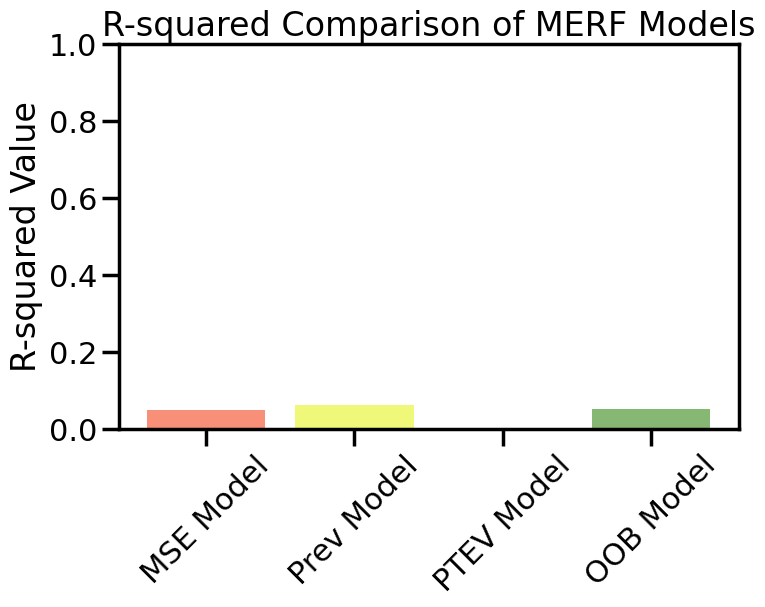

Best model: Prev Model with R-squared: 0.0632


In [31]:
train_l = train_delta[only_taxa]
test_l = test_delta[only_taxa]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_meta_taxa_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_meta_taxa_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_only_meta_taxa_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

#### Only micom delta

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 363.4831539994173 at iteration 1.
INFO     [merf.py:307] Training GLL is 370.394489331707 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 361.8602094103708 at iteration 1.
INFO     [merf.py:307] Training GLL is 369.65377920332725 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 244.65215186568005 at iteration 1.
INFO     [merf.py:307] Training GLL is 253.9600886656807 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 248.68143638549375 at iteration 1.
INFO     [merf.py:307] Training GLL is 250.05840342073452 at iteration 2.
INFO     [merf.py:307] Training GLL is 242.6050176589454 at iteration 3.
INFO     [merf.py:307] Training GLL is 237.7428719464437 at iteration 4.
INFO     [merf.py:307] Training GLL is 228.99501290541147 at iteration 5.
INFO     [merf.py:307] Training GLL is 223.29593371109488 at iteration 6.
INFO     [merf.py:307] Training GLL is 217.8742408901731 at iteration 7.
INFO     [merf.py:307] Training GLL is 211.9205864509648 at iteration 8.
INFO     [merf.py:307] Training GLL is 208.2796648050587 at iteration 9.
INFO     [merf.py:307] Training GLL is 202.86492619427267 at iteration 10.


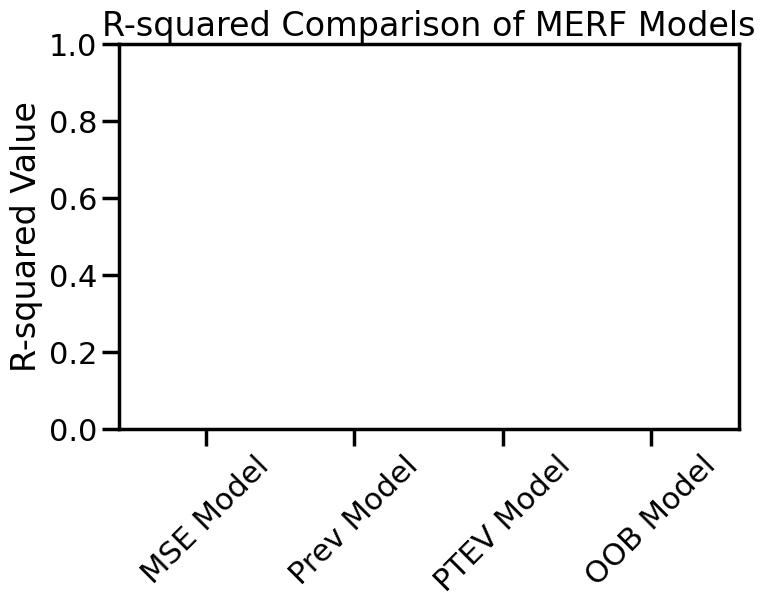

Best model: MSE Model with R-squared: -0.0127


In [32]:
train_l = train_delta[only_micom]
test_l = test_delta[only_micom]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_micom_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_micom_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_only_micom_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

#### Only pathway delta

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 331.6949153028858 at iteration 1.
INFO     [merf.py:307] Training GLL is 352.08434754219803 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:773: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 332.17334423367356 at iteration 1.
INFO     [merf.py:307] Training GLL is 351.34890850214754 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 233.3777846158318 at iteration 1.
INFO     [merf.py:307] Training GLL is 231.45460342379866 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 219.55911910966782 at iteration 1.
INFO     [merf.py:307] Training GLL is 230.48761730694872 at iteration 2.
INFO     [merf.py:307] Training GLL is 230.46801514490494 at iteration 3.
INFO     [merf.py:307] Training GLL is 223.67310284420898 at iteration 4.
INFO     [merf.py:307] Training GLL is 220.5105852333944 at iteration 5.
INFO     [merf.py:307] Training GLL is 217.20282887245216 at iteration 6.
INFO     [merf.py:307] Training GLL is 211.0976677358132 at iteration 7.
INFO     [merf.py:307] Training GLL is 204.63723641909837 at iteration 8.
INFO     [merf.py:307] Training GLL is 202.97734190820103 at iteration 9.
INFO     [merf.py:307] Training GLL is 198.2326136153693 at iteration 10.


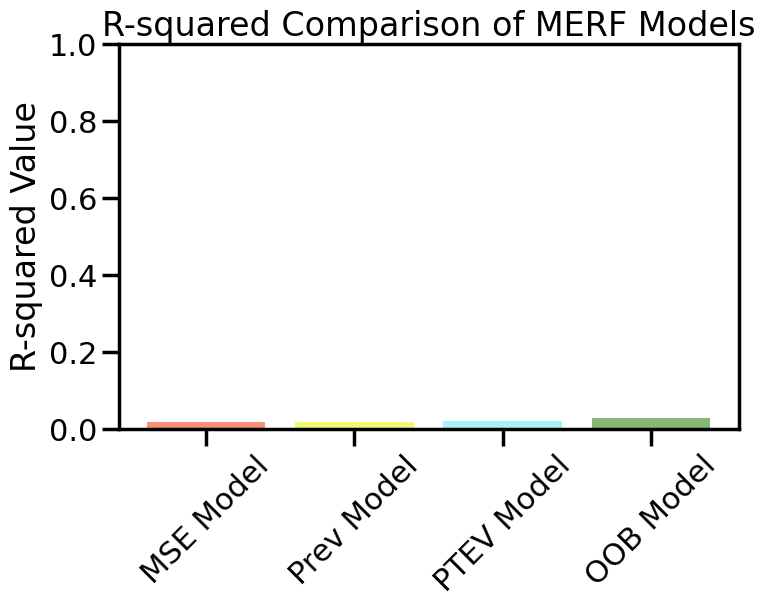

Best model: OOB Model with R-squared: 0.0281


In [36]:
train_l = train_delta[only_pathway]
test_l = test_delta[only_pathway]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_pathway_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_pathway_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_only_pathway_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.2 Ok now include meta and taxa deltas 

There is no change in bmi_prs so that is not included in the delta models 

In [ ]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_meta_taxa_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_meta_taxa_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_only_meta_taxa_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.3 Delta variables Meta + Taxa + Functional

In [18]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

In [ ]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

print("Columns in train_l DataFrame:")
print(list(train_l.columns))  # Convert to list for better readability

In [ ]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_meta_taxa_functional_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_meta_taxa_functional_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_meta_taxa_functional_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.4 all delta omics except meta 

In [ ]:


print("test longitudinal: ", list(test_l.columns))
print("train longitudinal: ", list(train_l.columns))

# Print duplicated column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
print("Duplicated columns in test_l: ", duplicates_test)

# Print duplicated column names in train_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
print("Duplicated columns in train_l: ", duplicates_train)


In [ ]:
train_l = train_delta.drop(all_but_meta, axis = 1)
test_l = test_delta.drop(all_but_meta, axis = 1)

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_taxa_functional_micom_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_taxa_functional_micom_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_taxa_functional_micom_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI','subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

## 2.5 all delta varibles 

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/delta_combined"
r2_out = 'r2_all_omic_merf_bmi_delta_feb12.png'
feature_imp_out = 'fi_all_omic_merf_bmi_delta_feb12.png'
results_filename = 'merf_results_delta_all_omic_feb12.csv'

print("---------- Select predictors for training set ----------")
train_set = train_delta
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_delta
X_new = test_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))
time_new = pd.Series(test_set['range'])
print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

#r2_delta_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             delta_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    delta_df,
    output_dir, r2_out, feature_imp_out, results_filename, time_new
)

# Now you can use `top_features` for plotting or further analysis

# Comparing all models above 

In [21]:
def compare_r2_values1(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 
    print(r2_comparison_df.head(10).columns[:10])
    print(r2_comparison_df.head(10))

    # Sort the DataFrame by R-squared values in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=model_names, ascending=False)

    # Set up the bar positions
    num_runs = len(r2_comparison_df.columns)
    bar_width = 0.15  # Width of each bar
    x = np.arange(len(r2_comparison_df))  # The label locations

    # Create a color map for the models
    colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

    # Create bars for each model in each run
    for i in range(num_runs):
        plt.bar(x + i * bar_width, r2_comparison_df.iloc[:, i],  # Use plt.bar for vertical bars
                 width=bar_width, label=model_names[i], color=colors[i])  # Use model names for labels

    # Add labels, title, and custom x-axis tick labels
    plt.ylabel('R-squared Value')  # Change to y-label
    plt.title('R-squared Comparison of Different Runs')
    plt.ylim(0, 0.55)  # Assuming R-squared values are between 0 and 1
    plt.xticks(x + bar_width * (num_runs - 1) / 2, r2_comparison_df.index)  # Center the x-ticks
    plt.legend(title='Models', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values1(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
model_names_delta = ['Only Meta Delta',  
               'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']
compare_r2_values1(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values2(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(0.0, 0.35)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=9, 
               title_fontsize=8, ncol = 4, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values2(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
compare_r2_values2(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [ ]:
model_names_both = ['Only Meta Long', 'Meta GRS Long', 
               'Meta GRS Tax Long', 'Meta GRS Tax Func Long', 
               'All But Meta Long', 'All Omic Long', 
               'Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']

compare_r2_values2(model_names_both, 
                   r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6,
                   r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values3(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Sort the DataFrame by 'Model' and then by 'R-squared' in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=['Metric', 'R-squared'], ascending=[True, False])

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(-0.2, 0.2)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values3(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(dataframes):
    # Combine all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes)
    
    # Create a plot
    plt.figure(figsize=(12, 8))
    bar_width = 0.08
    # Plot each model's feature importance
    for model in combined_df['Model'].unique():
        model_data = combined_df[combined_df['Model'] == model]
        plt.bar(model_data['Feature'], model_data['Importance'], label=model)
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(rotation=45, fontsize=9)
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage
feature_importance_dfs = [fi_run1, fi_run2, fi_run3, fi_run4, fi_run5, fi_run6, fi_delta_run1, fi_delta_run2]
plot_feature_importance(feature_importance_dfs)

In [78]:
def plot_feature_importance(dataframes):
    combined_df = pd.concat(dataframes) # Combine all DataFrames 
    # Filter features with importance < 0.02 & negative importance in all models
    combined_df = combined_df[(combined_df['Importance'] >= 0.02) & 
                          (combined_df.groupby('Feature')['Importance'].transform('min') >= 0)]
    plt.figure(figsize=(12, 8))
    bar_width = 0.15 
    num_models = len(combined_df['Model'].unique())
    
    # Get unique features
    features = combined_df['Feature'].unique()
    x = np.arange(len(features))  # The label locations

    # Plot each model's feature importance
    for i, model in enumerate(combined_df['Model'].unique()):
        model_data = combined_df[combined_df['Model'] == model]
        
        # Ensure heights only includes matching features
        heights = model_data[model_data['Feature'].isin(features)]['Importance'] 
        model_x = x[:len(heights)] + i * bar_width  # Adjust x-coordinates for the current model
        plt.bar(model_x, heights, width=bar_width, label=model)
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(x + bar_width * (num_models - 1) / 2, features, rotation=45, fontsize=9)  # Center x-ticks
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    plt.ylim(0, 0.6)
    plt.show()

In [81]:
def plot_feature_importance(dataframes, model_labels):
    combined_df = pd.concat(dataframes)  # Combine all DataFrames 
    # Filter features with importance < 0.02 & negative importance in all models
    combined_df = combined_df[(combined_df['Importance'] >= 0.02) & 
                              (combined_df.groupby('Feature')['Importance'].transform('min') >= 0)]
    plt.figure(figsize=(12, 8))
    bar_width = 0.15 
    num_models = len(combined_df['Model'].unique())
    
    # Get unique features
    features = combined_df['Feature'].unique()
    x = np.arange(len(features))  # The label locations

    # Plot each model's feature importance
    for i, model in enumerate(combined_df['Model'].unique()):
        model_data = combined_df[combined_df['Model'] == model]
        
        # Ensure heights only includes matching features
        heights = model_data[model_data['Feature'].isin(features)]['Importance'] 
        model_x = x[:len(heights)] + i * bar_width  # Adjust x-coordinates for the current model
        plt.bar(model_x, heights, width=bar_width, label=model_labels[i])  # Use custom labels
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(x + bar_width * (num_models - 1) / 2, features, rotation=45, fontsize=9)  # Center x-ticks
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    plt.ylim(0, 0.6)
    plt.show()

In [83]:
model_labels_long = ['Only Meta', 'Meta GRS', 'Meta GRS Tax', 'Meta GRS Tax Func', 'All But Meta', 'All Omic']
model_labels_delta = ['Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta', 'All But Meta Delta', 'All Omic Delta']
fi_long = [fi_run1, fi_run2, fi_run3, fi_run3, fi_run4, fi_run5, fi_run6]
fi_delta = [fi_delta_run1, fi_delta_run2, fi_delta_run3, fi_delta_run4, fi_delta_run5]

In [ ]:
plot_feature_importance(fi_long, model_labels_long)

In [ ]:
plot_feature_importance(fi_delta, model_labels_delta)